# All LSTM classification runs for Operator 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore

In [2]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 16})

## Processing functions

In [3]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

## LSTM functions

In [19]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': 
            curr_campaign = f['campaign'].iloc[i]

        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1:
            continue
    
        elif curr_campaign != f['campaign'].iloc[i]: 
            curr_campaign = f['campaign'].iloc[i]
        
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)

def long_short_term_memory(train, test, target_feature:str, features:list, n_steps_in=5, n_steps_out=1, units=[5, 10]):

    features.remove('Mode')
    
    X, y = series_split_sequences(train[features], train[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
    X_test, y_test = series_split_sequences(test[features], test[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)

    features.remove('campaign')

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    model = Sequential()
    if len(units) > 1:
        for unit in units[0:-1]:
            model.add(LSTM(units=unit,
                        activation='relu', recurrent_activation='sigmoid',
                        return_sequences=True, return_state=False
                        ))
            model.add(Dropout(0.2))
    model.add(LSTM(units=units[-1],
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), shuffle=True, verbose=0)
    
    y_pred = model.predict(X_test, verbose=0)
    y_pred = (y_pred >= 0.5).astype(int)

    train_pred = model.predict(X, verbose=0)
    train_pred = (train_pred >= 0.5).astype(int)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_test, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred
    
    accuracy, recall, precision = metrics(y_pred=y_pred, y_true=y_test)
    train_accuracy, train_recall, train_precision = metrics(y_pred=train_pred, y_true=y)

    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(y_test[:, i], y_pred[:, i]))
        train_acc.append(accuracy_score(y[:, i], train_pred[:, i]))
    
    results = {'y_pred': y_pred,
               'y_true': y_test,
               'train_true': y,
               'train_pred': train_pred,
               'y_pred_plot': y_pred_plot,
               'y_true_plot': y_true_plot,
               'train_pred_plot': train_pred_plot,
               'train_true_plot': train_true_plot,
               'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_list': acc,
               'Accuracy_train_list': train_acc
               }

    return results

def plot_mode(pred, true, operator:str, comb:str, n_steps_in:int, n_steps_out:int):
    fig = plt.figure(figsize=(10, 6))
    pred = plt.plot(np.array(pred), color=mode_colors[1], label='Predicted', zorder=2)
    true = plt.plot(np.array(true) + 2, color=mode_colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 3.6))
    plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
    plt.title(f'{operator}\nTraining features: {comb}\nLook-back: {n_steps_in}, Looh-ahead: {n_steps_out}')
    plt.legend(handles=[pred[0], true[0]], ncols=2, loc='best')
    plt.tight_layout()
    plt.show()
    return fig

'''
    Plots the accuracy in a histogram for test and training data
'''
def plot_accuracy_timesteps(true, pred, train_true, train_pred, comb:list, n_steps_out:int, operator:str):
    acc = []
    # train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(true[:, i], pred[:, i]))
        # train_acc.append(accuracy_score(train_true[:, i], train_pred[:, i]))

    # print(acc)
    # print(train_acc)

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']
    x = np.arange(n_steps_out)

    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 6))

    bars1 = ax.bar(x - width/2, acc, width, label='Accuracy', color=mode_colors[2], edgecolor='white')

    # bars2 = ax.bar(x + width/2, train_acc, width, label='Training Accuracy', color=mode_colors[3], edgecolor='white')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Step ahead')
    ax.set_title(f'{operator}\nAccuracy for each timestep ahead\nCombination of training features: {comb}')
    ax.set_xticks(x)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(labels[0:n_steps_out])
    ax.legend(loc='lower right')

    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_value_labels(bars1)
    # add_value_labels(bars2)

    plt.show()
    return fig

def box_lookback(results:dict, n_steps_out:int, operator:str, whiskers=(0, 100)):
    sep1 = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'] 
    comb1 = ['RSRP, SSS_RSRP', 'SINR, SSS_SINR', 'RSRQ, SSS_RSRQ']
    cat2 = ['RSRP, SINR', 'RSRP, RSRQ', 'SINR, RSRQ', 'SSS_RSRP, SSS_SINR', 'SSS_RSRP, SSS_RSRQ', 'SSS_SINR, SSS_RSRQ']
    sep3 = ['RSRP, SINR, RSRQ', 'SSS_RSRP, SSS_SINR, SSS_RSRQ']
    comb3 = ['All']

    names = ['Cat 1', 'Cat 2', 'Cat 3', 'Cat 4', 'All']

    xncombs = list(results.keys())
    
    accs = [[[] for _ in range(len(names))] for _ in range(len(xncombs))]

    for i in range(len(xncombs)):
        for key in results[xncombs[i]]:
            if key in sep1:
                for j in range(n_steps_out):
                    accs[i][0].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in comb1:
                for j in range(n_steps_out):
                    accs[i][1].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in cat2:
                for j in range(n_steps_out):
                    accs[i][2].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in sep3:
                for j in range(n_steps_out):
                    accs[i][3].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in comb3:
                for j in range(n_steps_out):
                    accs[i][4].append(results[xncombs[i]][key]['Accuracy_list'][j])

    flattened_data = []
    for group_index, group in enumerate(accs):
        for category_index, accuracies in enumerate(group):
            for accuracy in accuracies:
                flattened_data.append({
                    'Look-back': xncombs[group_index],
                    'Category': names[category_index],
                    'Accuracy': accuracy
                })

    df = pd.DataFrame(flattened_data)

    fig = plt.figure(figsize=(10, 6))
    sns.boxplot(x='Look-back', y='Accuracy', hue='Category', data=df, palette=sns.color_palette('Greens'), whis=whiskers, gap=0.1, zorder=2)
    plt.grid(zorder=0)

    means = df.groupby(['Look-back', 'Category'])['Accuracy'].mean().reset_index()
    i = 0
    for _, row in means.iterrows():
        if row['Category'] == 'All':
            plt.annotate(f'{row["Accuracy"]:.2f}', 
                        xy=(i + 0.32, row['Accuracy']), 
                        xytext=(0, 5),
                        textcoords='offset points', 
                        ha='center',
                        color='black', 
                        fontsize=9)
            i += 1
        
    plt.title(f'{operator}\nAccuracies by Look-Back and Feature Combination\nLook-ahead is {n_steps_out} time steps')
    plt.legend(ncols=3)
    plt.ylim((0, 1))
    plt.tight_layout()
    plt.show()

    return fig

'''
    Plots the accuracy for each timestep ahead for both test and training data
'''
def boxplot_accuracies(results:dict, n_steps_out:str, n_steps_in:str, whiskers=[5, 95]):
    accuracy = [[] for _ in range(n_steps_out)]
    accuracy_train = [[] for _ in range(n_steps_out)]

    for key in results:
        for i in range(n_steps_out):
            accuracy[i].append(results[key]['Accuracy_list'][i])
            accuracy_train[i].append(results[key]['Accuracy_train_list'][i])

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig = plt.figure(figsize=(10, 6))
    sns.boxplot(data=np.array(accuracy).T, color=sinr_colors[2], whis=whiskers, zorder=2)
    plt.title(f'Accuracy per time step with look-back of {n_steps_in}')
    plt.ylabel('Accuracy')
    plt.xlabel('Steps ahead')
    plt.xticks(range(n_steps_out), labels[0:n_steps_out])
    plt.grid(zorder=0)
    plt.tight_layout()
    plt.show()
    return fig

In [5]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op1_merged.csv'
operator = 'Operator 1'

In [6]:
overlap = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
           'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
           'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
           'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
           'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
           'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']
test = read_dataset(dataset, campaigns=[overlap[0]])
train = read_dataset(dataset, campaigns=overlap[1:4])

route_to_add = read_dataset(dataset, campaigns=[overlap[4]])
train = pd.concat([route_to_add[5400::], train])
train.reset_index(drop=True, inplace=True)

route_to_add = read_dataset(dataset, campaigns=[overlap[5]])
train = pd.concat([route_to_add[0:1180], train])
train.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [7]:
target_features = ['Mode']
units = [10, 10, 10]
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

In [8]:
n_steps_ins, n_steps_out = [1, 2, 5], 1

step1_results = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    step1_results[f'x:{n_steps_in}'] = temp_results

In [9]:

x1n1 = step1_results['x:1']

x1n1_results = pd.DataFrame.from_dict(x1n1, orient='index')
x1n1_results.reset_index(inplace=True)
x1n1_results.rename(columns={'index': 'Combination'}, inplace=True)
x1n1_results = x1n1_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x1n1_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.548,0.000,0.000,0.773,0.000,0.000
1,SINR,0.549,0.513,0.044,0.764,0.430,0.114
2,RSRQ,0.548,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.548,0.000,0.000,0.773,0.000,0.000
4,"RSRP, RSRQ",0.548,0.000,0.000,0.773,0.000,0.000
5,"SINR, RSRQ",0.548,0.000,0.000,0.773,0.000,0.000
6,"RSRP, SINR, RSRQ",0.548,0.000,0.000,0.773,0.000,0.000
7,SSS_RSRP,0.548,0.000,0.000,0.773,0.000,0.000
8,SSS_SINR,0.562,0.561,0.139,0.738,0.427,0.439
9,SSS_RSRQ,0.665,0.655,0.544,0.693,0.419,0.908


In [10]:
x2n1 = step1_results['x:2']

x2n1_results = pd.DataFrame.from_dict(x2n1, orient='index')
x2n1_results.reset_index(inplace=True)
x2n1_results.rename(columns={'index': 'Combination'}, inplace=True)
x2n1_results = x2n1_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x2n1_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.000,0.000,0.773,0.000,0.000
1,SINR,0.542,0.404,0.028,0.774,0.512,0.137
2,RSRQ,0.549,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.533,0.479,0.393,0.709,0.371,0.400
4,"RSRP, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
5,"SINR, RSRQ",0.536,0.382,0.045,0.752,0.392,0.167
6,"RSRP, SINR, RSRQ",0.427,0.419,0.694,0.520,0.292,0.779
7,SSS_RSRP,0.575,0.601,0.175,0.741,0.199,0.046
8,SSS_SINR,0.567,0.566,0.178,0.746,0.451,0.539
9,SSS_RSRQ,0.650,0.629,0.549,0.671,0.404,0.944


In [11]:
x5n1 = step1_results['x:5']

x5n1_results = pd.DataFrame.from_dict(x5n1, orient='index')
x5n1_results.reset_index(inplace=True)
x5n1_results.rename(columns={'index': 'Combination'}, inplace=True)
x5n1_results = x5n1_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x5n1_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.000,0.000,0.773,0.000,0.000
1,SINR,0.545,0.453,0.047,0.756,0.390,0.137
2,RSRQ,0.549,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.526,0.476,0.512,0.597,0.234,0.342
4,"RSRP, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
5,"SINR, RSRQ",0.595,0.631,0.245,0.799,0.584,0.387
6,"RSRP, SINR, RSRQ",0.614,0.667,0.289,0.564,0.044,0.045
7,SSS_RSRP,0.565,0.555,0.174,0.719,0.402,0.496
8,SSS_SINR,0.575,0.596,0.175,0.754,0.460,0.488
9,SSS_RSRQ,0.596,0.615,0.276,0.749,0.465,0.715


In [12]:
accuracy = (x1n1_results['Accuracy'].mean() + x2n1_results['Accuracy'].mean() + x5n1_results['Accuracy'].mean())/3
precision = (x1n1_results['Precision'].mean() + x2n1_results['Precision'].mean() + x5n1_results['Precision'].mean())/3
recall = (x1n1_results['Recall'].mean() + x2n1_results['Recall'].mean() + x5n1_results['Recall'].mean())/3

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.578
Mean precision: 0.432
Mean recall: 0.269


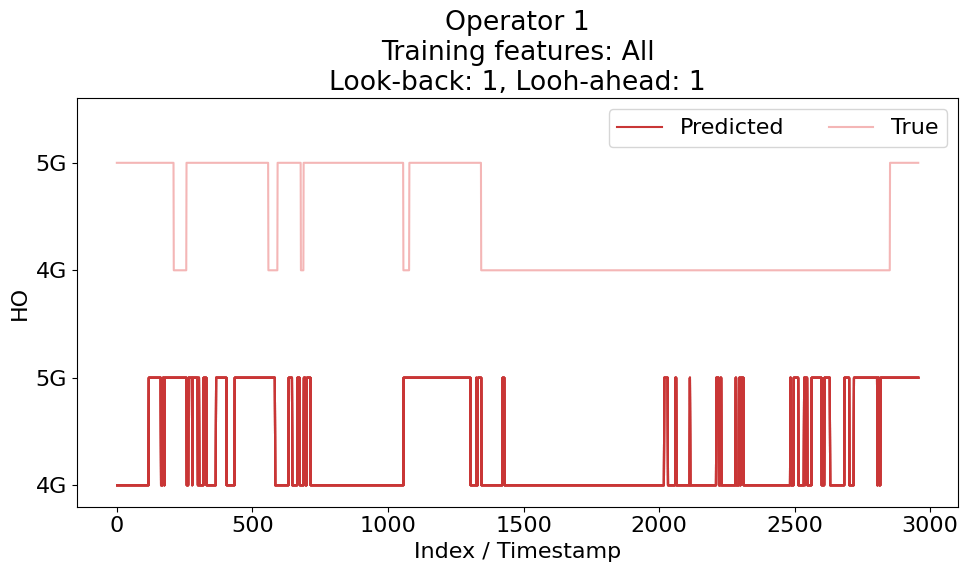

In [13]:
combination = 'All'
comb = x1n1[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

fig = plot_mode(pred=pred, true=true, operator=operator, comb=combination, n_steps_in=1, n_steps_out=1)
fig.savefig(r'../latex/plots/lstm_mode/op1_1_look-back_1_look-ahead.pdf')

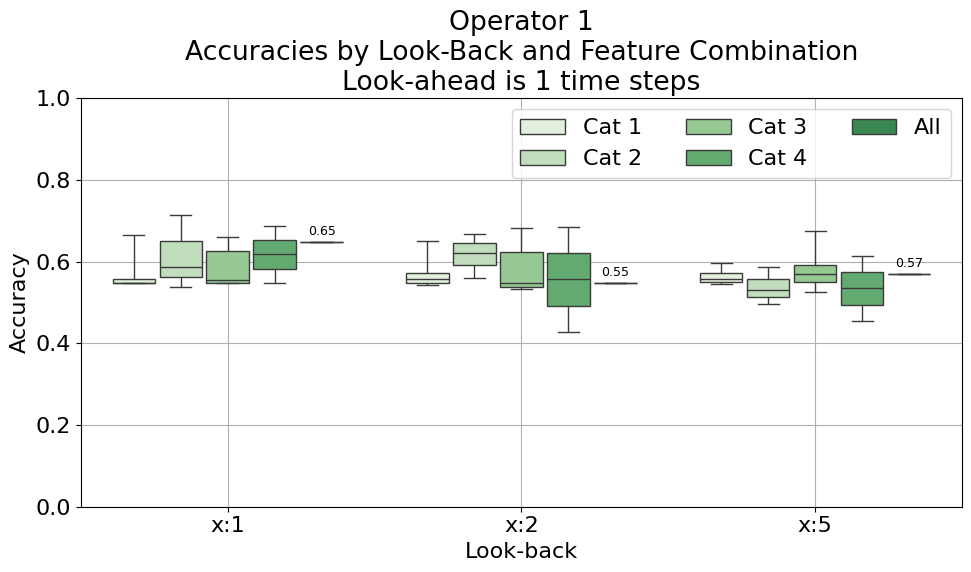

In [20]:
fig = box_lookback(step1_results, n_steps_out=1, operator=operator)
fig.savefig(r'../latex/plots/lstm_mode/op1_violin_n1.pdf')

In [15]:
# n_steps_ins, n_steps_out = [1, 2, 5], 2

# step2_results = {}

# for n_steps_in in n_steps_ins:
#     temp_results = {}
#     for target in target_features:
#         for features in feature_selection:
#             used_features = f''
#             if len(features) == 6:
#                 used_features = 'All'
#             else:
#                 used_features = ', '.join(features)
#             features.append('campaign')
#             features.append('Mode')
#             warnings.simplefilter(action='ignore')
#             temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
#     step2_results[f'x:{n_steps_in}'] = temp_results

In [16]:
# x1n2 = step2_results['x:1']

# x1n2_results = pd.DataFrame.from_dict(x1n2, orient='index')
# x1n2_results.reset_index(inplace=True)
# x1n2_results.rename(columns={'index': 'Combination'}, inplace=True)
# x1n2_results = x1n2_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
# x1n2_results

In [17]:
# x2n2 = step2_results['x:2']

# x2n2_results = pd.DataFrame.from_dict(x2n2, orient='index')
# x2n2_results.reset_index(inplace=True)
# x2n2_results.rename(columns={'index': 'Combination'}, inplace=True)
# x2n2_results = x2n2_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
# x2n2_results

In [18]:
# x5n2 = step2_results['x:5']

# x5n2_results = pd.DataFrame.from_dict(x5n2, orient='index')
# x5n2_results.reset_index(inplace=True)
# x5n2_results.rename(columns={'index': 'Combination'}, inplace=True)
# x5n2_results = x5n2_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
# x5n2_results

In [19]:
# fig = box_lookback(step2_results, n_steps_out=2, operator=operator)
# fig.savefig(r'../latex/plots/lstm_mode/op1_violin_n2.pdf')

In [20]:
# fig = boxplot_accuracies(step2_results['x:1'], n_steps_out=2, n_steps_in=1)
# fig.savefig(r'../latex/plots/lstm_mode/op1_box_x1n2.pdf')

In [21]:
n_steps_ins, n_steps_out = [1, 3, 5], 3

step3_results = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    step3_results[f'x:{n_steps_in}'] = temp_results

In [22]:
x1n3 = step3_results['x:1']

x1n3_results = pd.DataFrame.from_dict(x1n3, orient='index')
x1n3_results.reset_index(inplace=True)
x1n3_results.rename(columns={'index': 'Combination'}, inplace=True)
x1n3_results = x1n3_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x1n3_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.000,0.000,0.773,0.000,0.000
1,SINR,0.535,0.188,0.009,0.775,0.547,0.045
2,RSRQ,0.549,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.549,0.000,0.000,0.773,0.000,0.000
4,"RSRP, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
5,"SINR, RSRQ",0.550,0.513,0.044,0.767,0.441,0.096
6,"RSRP, SINR, RSRQ",0.551,0.533,0.042,0.784,0.590,0.157
7,SSS_RSRP,0.549,0.000,0.000,0.773,0.000,0.000
8,SSS_SINR,0.564,0.593,0.108,0.749,0.432,0.337
9,SSS_RSRQ,0.649,0.658,0.464,0.723,0.442,0.822


In [23]:
x3n3 = step3_results['x:3']

x3n3_results = pd.DataFrame.from_dict(x3n3, orient='index')
x3n3_results.reset_index(inplace=True)
x3n3_results.rename(columns={'index': 'Combination'}, inplace=True)
x3n3_results = x3n3_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x3n3_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.000,0.000,0.773,0.000,0.000
1,SINR,0.525,0.366,0.072,0.771,0.486,0.160
2,RSRQ,0.549,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.568,0.537,0.303,0.736,0.390,0.287
4,"RSRP, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
5,"SINR, RSRQ",0.607,0.612,0.351,0.769,0.479,0.220
6,"RSRP, SINR, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
7,SSS_RSRP,0.539,0.404,0.046,0.754,0.386,0.145
8,SSS_SINR,0.576,0.595,0.187,0.752,0.460,0.556
9,SSS_RSRQ,0.654,0.663,0.472,0.724,0.442,0.832


In [24]:
x5n3 = step3_results['x:5']

x5n3_results = pd.DataFrame.from_dict(x5n3, orient='index')
x5n3_results.reset_index(inplace=True)
x5n3_results.rename(columns={'index': 'Combination'}, inplace=True)
x5n3_results = x5n3_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x5n3_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.000,0.000,0.774,0.000,0.000
1,SINR,0.549,0.496,0.044,0.770,0.468,0.133
2,RSRQ,0.549,0.000,0.000,0.774,0.000,0.000
3,"RSRP, SINR",0.549,0.500,0.011,0.639,0.017,0.010
4,"RSRP, RSRQ",0.549,0.000,0.000,0.774,0.000,0.000
5,"SINR, RSRQ",0.588,0.568,0.355,0.777,0.516,0.236
6,"RSRP, SINR, RSRQ",0.525,0.455,0.275,0.707,0.381,0.471
7,SSS_RSRP,0.435,0.173,0.067,0.572,0.000,0.000
8,SSS_SINR,0.576,0.593,0.186,0.754,0.462,0.538
9,SSS_RSRQ,0.651,0.660,0.467,0.727,0.445,0.828


In [25]:
accuracy = (x1n3_results['Accuracy'].mean() + x3n3_results['Accuracy'].mean() + x5n3_results['Accuracy'].mean())/3
precision = (x1n3_results['Precision'].mean() + x3n3_results['Precision'].mean() + x5n3_results['Precision'].mean())/3
recall = (x1n3_results['Recall'].mean() + x3n3_results['Recall'].mean() + x5n3_results['Recall'].mean())/3

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.584
Mean precision: 0.430
Mean recall: 0.234


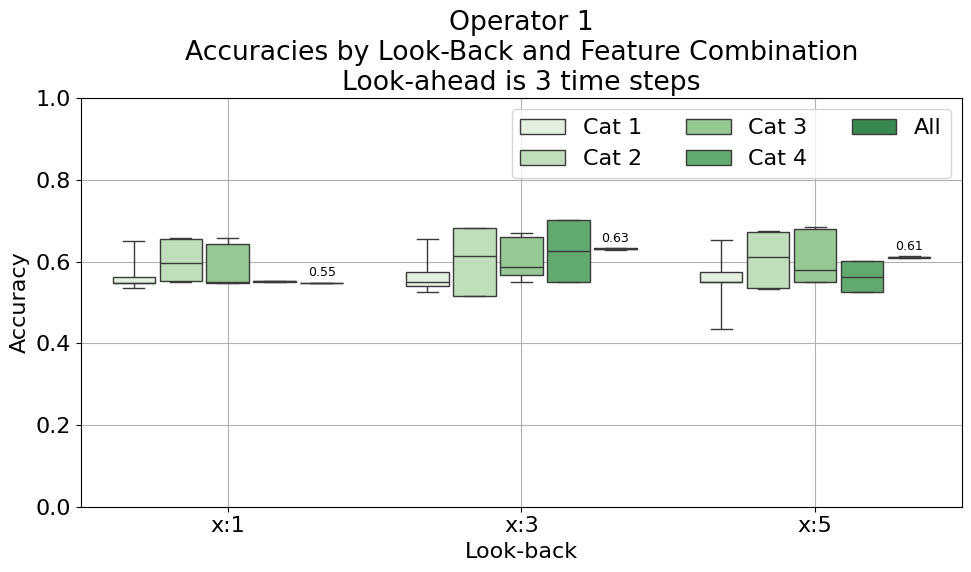

In [26]:
fig = box_lookback(step3_results, n_steps_out=3, operator=operator)
fig.savefig(r'../latex/plots/lstm_mode/op1_violin_n3.pdf')

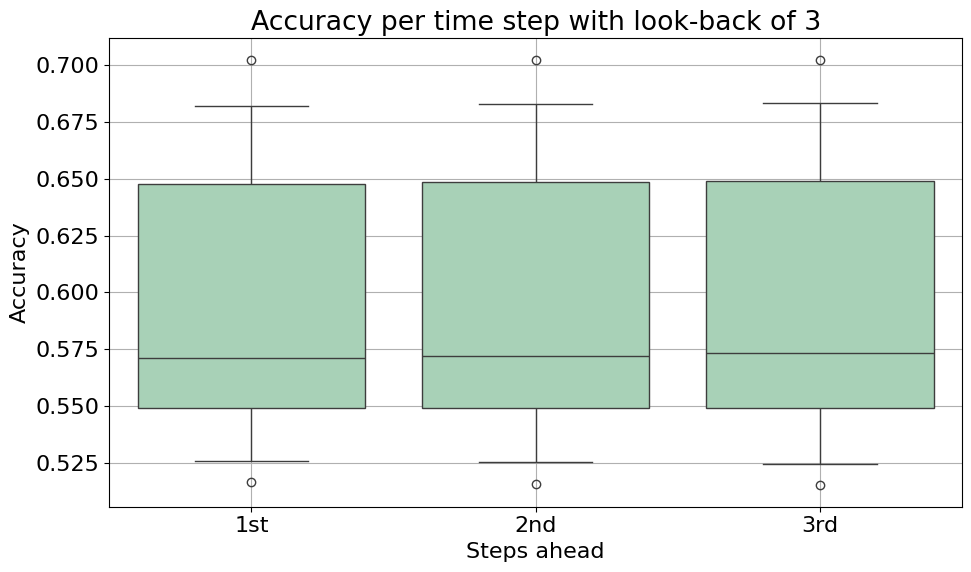

In [27]:
fig = boxplot_accuracies(x3n3, n_steps_out=3, n_steps_in=3)
# fig.savefig(r'../latex/plots/lstm_mode/op1_box_x3n3.pdf')

In [28]:
n_steps_ins, n_steps_out = [2, 5, 8], 5

step5_results = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    step5_results[f'x:{n_steps_in}'] = temp_results

In [29]:
x2n5 = step5_results['x:2']

x2n5_results = pd.DataFrame.from_dict(x2n5, orient='index')
x2n5_results.reset_index(inplace=True)
x2n5_results.rename(columns={'index': 'Combination'}, inplace=True)
x2n5_results = x2n5_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x2n5_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.000,0.000,0.773,0.000,0.000
1,SINR,0.535,0.191,0.010,0.781,0.683,0.063
2,RSRQ,0.549,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.544,0.255,0.006,0.757,0.345,0.080
4,"RSRP, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
5,"SINR, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
6,"RSRP, SINR, RSRQ",0.717,0.668,0.741,0.582,0.251,0.425
7,SSS_RSRP,0.564,0.569,0.133,0.748,0.437,0.389
8,SSS_SINR,0.575,0.605,0.165,0.747,0.444,0.456
9,SSS_RSRQ,0.658,0.661,0.495,0.717,0.439,0.885


In [30]:
x5n5 = step5_results['x:5']

x5n5_results = pd.DataFrame.from_dict(x5n5, orient='index')
x5n5_results.reset_index(inplace=True)
x5n5_results.rename(columns={'index': 'Combination'}, inplace=True)
x5n5_results = x5n5_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x5n5_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.550,0.000,0.000,0.774,0.000,0.000
1,SINR,0.551,0.511,0.042,0.771,0.481,0.133
2,RSRQ,0.550,0.000,0.000,0.774,0.000,0.000
3,"RSRP, SINR",0.552,0.508,0.172,0.773,0.497,0.313
4,"RSRP, RSRQ",0.550,0.000,0.000,0.774,0.000,0.000
5,"SINR, RSRQ",0.642,0.686,0.377,0.777,0.513,0.253
6,"RSRP, SINR, RSRQ",0.581,0.558,0.334,0.721,0.397,0.452
7,SSS_RSRP,0.565,0.652,0.074,0.728,0.288,0.137
8,SSS_SINR,0.578,0.615,0.169,0.766,0.482,0.474
9,SSS_RSRQ,0.596,0.661,0.210,0.770,0.494,0.646


In [31]:
x8n5 = step5_results['x:8']

x8n5_results = pd.DataFrame.from_dict(x8n5, orient='index')
x8n5_results.reset_index(inplace=True)
x8n5_results.rename(columns={'index': 'Combination'}, inplace=True)
x8n5_results = x8n5_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x8n5_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.550,0.000,0.000,0.775,0.000,0.000
1,SINR,0.510,0.332,0.090,0.757,0.446,0.325
2,RSRQ,0.550,0.000,0.000,0.775,0.000,0.000
3,"RSRP, SINR",0.561,0.604,0.068,0.775,0.508,0.043
4,"RSRP, RSRQ",0.550,0.000,0.000,0.775,0.000,0.000
5,"SINR, RSRQ",0.619,0.657,0.318,0.805,0.595,0.418
6,"RSRP, SINR, RSRQ",0.536,0.440,0.117,0.775,0.505,0.104
7,SSS_RSRP,0.620,0.549,0.869,0.461,0.262,0.766
8,SSS_SINR,0.584,0.626,0.186,0.780,0.513,0.515
9,SSS_RSRQ,0.599,0.636,0.255,0.762,0.481,0.694


In [32]:
accuracy = (x2n5_results['Accuracy'].mean() + x5n5_results['Accuracy'].mean() + x8n5_results['Accuracy'].mean())/3
precision = (x2n5_results['Precision'].mean() + x5n5_results['Precision'].mean() + x8n5_results['Precision'].mean())/3
recall = (x2n5_results['Recall'].mean() + x5n5_results['Recall'].mean() + x8n5_results['Recall'].mean())/3

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.588
Mean precision: 0.476
Mean recall: 0.273


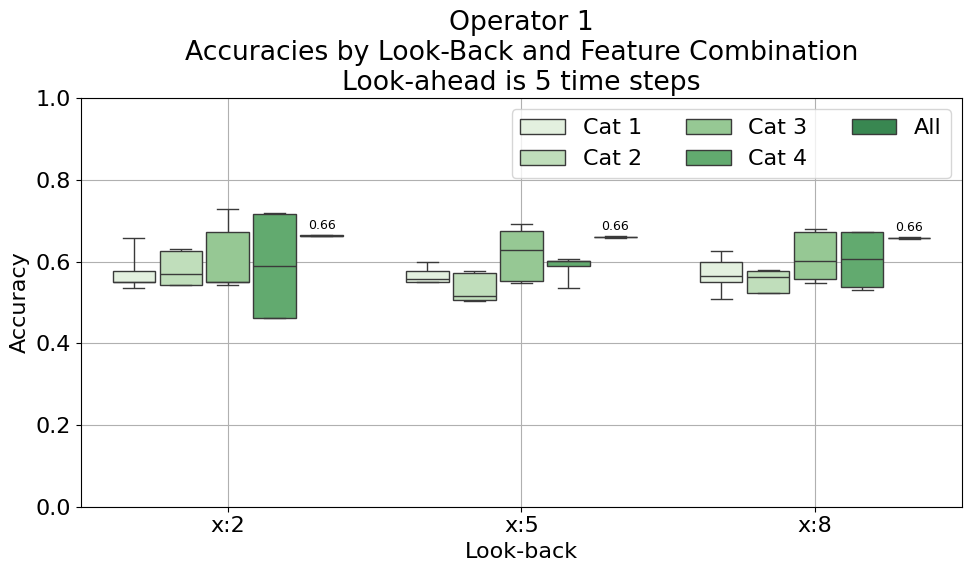

In [33]:
fig = box_lookback(step5_results, n_steps_out=5, operator=operator)
fig.savefig(r'../latex/plots/lstm_mode/op1_violin_n5.pdf')

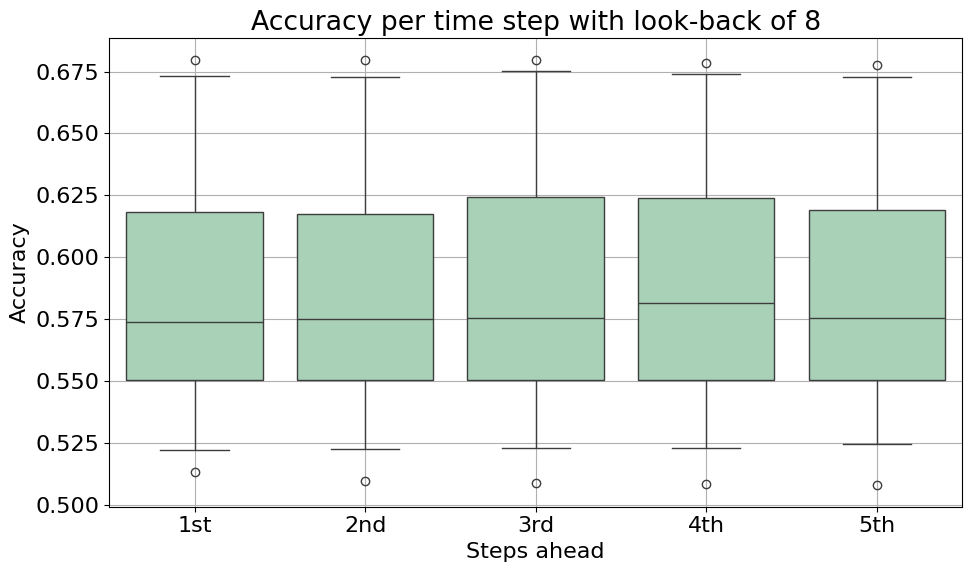

In [34]:
fig = boxplot_accuracies(x8n5, n_steps_out=5, n_steps_in=8)
# fig.savefig(r'../latex/plots/lstm_mode/op1_box_x8n5.pdf')

In [35]:
# n_steps_ins, n_steps_out = [2, 5, 10, 15], 10

# step10_results = {}

# for n_steps_in in n_steps_ins:
#     temp_results = {}
#     for target in target_features:
#         for features in feature_selection:
#             used_features = f''
#             if len(features) == 6:
#                 used_features = 'All'
#             else:
#                 used_features = ', '.join(features)
#             features.append('campaign')
#             features.append('Mode')
#             warnings.simplefilter(action='ignore')
#             temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
#     step10_results[f'x:{n_steps_in}'] = temp_results

In [36]:
# x2n10 = step10_results['x:2']

# x2n10_results = pd.DataFrame.from_dict(x2n10, orient='index')
# x2n10_results.reset_index(inplace=True)
# x2n10_results.rename(columns={'index': 'Combination'}, inplace=True)
# x2n10_results = x2n10_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
# x2n10_results

In [37]:
# x5n10 = step10_results['x:5']

# x5n10_results = pd.DataFrame.from_dict(x5n10, orient='index')
# x5n10_results.reset_index(inplace=True)
# x5n10_results.rename(columns={'index': 'Combination'}, inplace=True)
# x5n10_results = x5n10_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
# x5n10_results

In [38]:
# x10n10 = step10_results['x:10']

# x10n10_results = pd.DataFrame.from_dict(x10n10, orient='index')
# x10n10_results.reset_index(inplace=True)
# x10n10_results.rename(columns={'index': 'Combination'}, inplace=True)
# x10n10_results = x10n10_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
# x10n10_results

In [39]:
# x15n10 = step10_results['x:15']

# x15n10_results = pd.DataFrame.from_dict(x15n10, orient='index')
# x15n10_results.reset_index(inplace=True)
# x15n10_results.rename(columns={'index': 'Combination'}, inplace=True)
# x15n10_results = x15n10_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
# x15n10_results

In [40]:
# fig = box_lookback(step10_results, n_steps_out=10, operator=operator)
# fig.savefig(r'../latex/plots/lstm_mode/op1_violin_n10.pdf')

In [41]:
# fig = boxplot_accuracies(x10n10, n_steps_out=10, n_steps_in=10)
# fig.savefig(r'../latex/plots/lstm_mode/op1_box_x10n10.pdf')